## **This is second part where we are training our Indian Vehicle CNN Classification model for predicting Indian vehicles with better accuracy.**

**#################################################################################################**

In [ ]:
# [1]. This section is used to upload Custom Indian Vehicle dataset zip file in Google colab for making H5 model for Indian Vehicle CNN Classifier.

from google.colab import files
import zipfile
import os

# Step 1: Upload the ZIP file
uploaded = files.upload()

# Step 2: Extract the ZIP file (assuming only one file was uploaded)
for zip_filename in uploaded.keys():
    if zip_filename.endswith(".zip"):
        extract_dir = zip_filename.replace(".zip", "")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"✅ Extracted '{zip_filename}' to folder '{extract_dir}'")
    else:
        print("⚠️ Please upload a .zip file.")

Saving I_V_dataset.zip to I_V_dataset.zip
✅ Extracted 'I_V_dataset.zip' to folder 'I_V_dataset'


**###################################################################################**

Found 988 images belonging to 5 classes.
Found 245 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.3319 - loss: 1.7926 - val_accuracy: 0.8245 - val_loss: 0.6375
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5689 - loss: 1.0619 - val_accuracy: 0.8163 - val_loss: 0.5244
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.6504 - loss: 0.9103 - val_accuracy: 0.8694 - val_loss: 0.4206
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.6856 - loss: 0.7958 - val_accuracy: 0.8449 - val_loss: 0.4257
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7317 - loss: 0.7218 - val_accuracy: 0.8653 - val_loss: 0.3792
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7452 - loss: 0.7107 - val_accuracy: 0.8735 - val_loss: 0.3701
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7295 - loss: 0.6445 - val_accuracy: 0.9265 - val_

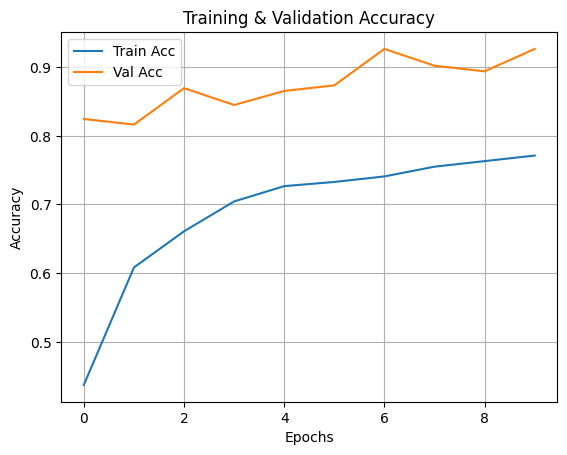

In [ ]:
# [2]. This section is used to trained top layer of MobileNetV2 CNN Model by freezing base layer through using Transfer Learning.

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = "I_V_dataset"

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
)

# Train and validation loaders
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load base model (MobileNetV2)
base_model = MobileNetV2(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers initially

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Evaluate
val_loss, val_acc = model.evaluate(val_generator)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}% | Loss: {val_loss:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# [3]. This line of code is used to save model, so that you don't have to trained it everytime.
model.save("I_V_classifier_final_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


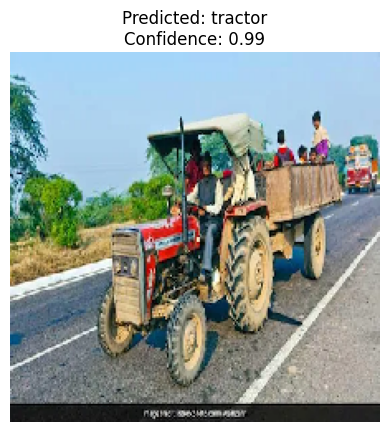

In [ ]:
# [4]. This section is used to check the prediction or classification on an unseen image.

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# 1. Load the trained model
model = load_model('/content/I_V_classifier_final_model.h5')  # Path to your .h5 model

# 2. Define class names (adjust these based on your training)
class_names = ['auto_rickshaw', 'indian_bus', 'indian_mini_truck', 'indian_truck', 'tractor']

# 3. Upload or define path of unseen images
unseen_image_path = '/content/tractor-generic-istock_650x400_51495708064.webp'   # Path to your unseen image file

# 4. Prediction Function
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    confidence = np.max(predictions)

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

# 5. Predict on the unseen image
predict_image(unseen_image_path)